In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_ta as ta

In [35]:
df = pd.read_parquet("../data/coin-data-hourly.parquet")

In [36]:
df

,Date,Close,High,Low,Open,Volume,Symbol
0,2024-01-20 00:00:00,41480.117188,41640.230469,41446.824219,41624.589844,0,BTC-USD
1,2024-01-20 01:00:00,41604.789062,41646.871094,41469.070312,41469.070312,0,BTC-USD
2,2024-01-20 02:00:00,41575.363281,41622.125000,41522.097656,41622.125000,0,BTC-USD
3,2024-01-20 03:00:00,41624.578125,41624.578125,41512.343750,41589.242188,0,BTC-USD
4,2024-01-20 04:00:00,41585.972656,41630.390625,41562.292969,41611.378906,0,BTC-USD
...,...,...,...,...,...,...,...
17333,2026-01-17 17:00:00,95323.453125,95398.703125,95259.070312,95277.421875,0,BTC-USD
17334,2026-01-17 18:00:00,95382.875000,95428.242188,95330.414062,95330.414062,0,BTC-USD
17335,2026-01-17 19:00:00,95261.351562,95396.429688,95247.890625,95396.429688,0,BTC-USD
17336,2026-01-17 20:00:00,95343.679688,95345.164062,95242.265625,95259.257812,0,BTC-USD


In [37]:
def add_features(df):
    df = df.copy()
    df.sort_values(["Symbol", "Date"], inplace=True)

    def compute_indicators(group):
        # --- Trend & Momentum ---
        group.ta.ema(length=9, append=True)
        group.ta.ema(length=21, append=True)
        group.ta.ema(length=50, append=True)
        group.ta.ema(
            length=200, append=True
        )  # Uzun vadeli trend filtresi (Hourly'de önemli)

        # --- Oscillators ---
        group.ta.rsi(length=14, append=True)
        group.ta.stochrsi(length=14, append=True)  # Daha hassas zamanlama için
        group.ta.cci(length=20, append=True)  # Döngüsel dönüşleri yakalamak için

        # --- Trend Strength (Çok Önemli) ---
        group.ta.adx(length=14, append=True)  # Trendin gücünü ölçer (Yönü değil)

        # --- Volatility ---
        group.ta.bbands(length=20, std=2, append=True)
        group.ta.atr(length=14, append=True)

        # --- Volume & Flow ---
        group.ta.obv(append=True)
        group.ta.mfi(length=14, append=True)  # Money Flow Index (Hacim ağırlıklı RSI)
        group.ta.cmf(
            length=20, append=True
        )  # Chaikin Money Flow (Kurumsal para girişi)

        group.ta.log_return(append=True)
        group.ta.macd(fast=12, slow=26, signal=9, append=True)
        return group

    def rename_columns(group):
        # Pandas TA bazen dinamik isimlendirme yapar, bunları sabitleyelim
        # Not: Sütun isimleri versiyona göre değişebilir, debug gerekebilir.
        rename_map = {
            "EMA_9": "EMA_SHORT",
            "EMA_21": "EMA_MID",
            "EMA_50": "EMA_LONG",
            "EMA_200": "EMA_TREND",
            "RSI_14": "RSI",
            "STOCHRSIk_14_14_3_3": "STOCH_K",
            "STOCHRSId_14_14_3_3": "STOCH_D",
            "ADX_14": "ADX",
            "DMP_14": "ADX_POS",  # Positive Directional Index
            "DMN_14": "ADX_NEG",  # Negative Directional Index
            "CCI_20_0.015": "CCI",
            "ATRr_14": "ATR",
            "MFI_14": "MFI",
            "CMF_20": "CMF",
            "OBV": "OBV",
            "LOGRET_1": "LOG_RET",
            "MACD_12_26_9": "MACD_LINE",
            "MACDh_12_26_9": "MACD_HIST",
            "MACDs_12_26_9": "MACD_SIGNAL",
            "BBU_20_2.0": "BB_UPPER",
            "BBL_20_2.0": "BB_LOWER",
            "BBM_20_2.0": "BB_MID",
        }

        # Sütun isimlerini güvenli şekilde değiştir (Sadece var olanları)
        cols_found = [c for c in rename_map.keys() if c in group.columns]
        actual_map = {k: rename_map[k] for k in cols_found}
        group.rename(columns=actual_map, inplace=True)
        return group

    def custom_features(group):
        # 1. Price Action / Mum Yapısı (Modelin mumu "görmesini" sağlar)
        # ---------------------------------------------------------
        close = group["Close"]
        open_ = group["Open"]
        high = group["High"]
        low = group["Low"]

        # Mum gövde ve fitil boyutları
        group["candle_body"] = abs(close - open_)
        group["candle_range"] = high - low
        group["upper_wick"] = high - group[["Open", "Close"]].max(axis=1)
        group["lower_wick"] = group[["Open", "Close"]].min(axis=1) - low

        # Fitil Oranları (Rejection sinyalleri)
        # 0'a bölme hatasını önlemek için +1e-9
        group["upper_wick_ratio"] = group["upper_wick"] / (group["candle_body"] + 1e-9)
        group["lower_wick_ratio"] = group["lower_wick"] / (group["candle_body"] + 1e-9)

        # 2. Relative Volume (RVOL) - Kırılımların hacimli olup olmadığını söyler
        # ---------------------------------------------------------
        # Son 24 saatin ortalama hacmi
        vol_ma = group["Volume"].rolling(window=24).mean()
        group["RVOL"] = group["Volume"] / (vol_ma + 1e-9)

        # 3. Uzaklıklar ve Normalize Edilmiş Değerler
        # ---------------------------------------------------------
        # Fiyatın EMA'lardan ne kadar saptığı (Mean Reversion için)
        group["dist_ema_short"] = (close - group["EMA_SHORT"]) / group["EMA_SHORT"]
        group["dist_ema_long"] = (close - group["EMA_LONG"]) / group["EMA_LONG"]

        # Fiyat Bollinger Band'ın neresinde? (0: Alt bant, 1: Üst bant)
        if "BB_UPPER" in group.columns and "BB_LOWER" in group.columns:
            group["bb_position"] = (close - group["BB_LOWER"]) / (
                group["BB_UPPER"] - group["BB_LOWER"]
            )
            group["bb_width"] = (group["BB_UPPER"] - group["BB_LOWER"]) / group[
                "BB_MID"
            ]  # Volatilite sıkışması

        # 4. Sinyal Kombinasyonları (Interaction Features)
        # ---------------------------------------------------------
        # RSI ve MFI arasındaki uyumsuzluk (Divergence yakalamak zordur ama farkı model kullanabilir)
        if "MFI" in group.columns:
            group["rsi_mfi_diff"] = group["RSI"] - group["MFI"]

        # Trend Gücü Filtresi
        # ADX > 25 ise Trend var, değilse Range. Model bunu öğrenmeli.
        if "ADX" in group.columns:
            group["is_trending"] = (group["ADX"] > 25).astype(int)

        return group

    def add_lags(group):
        # Lag'ler modelin "bir önceki mumda ne oldu?" sorusunu yanıtlar
        cols_to_lag = ["LOG_RET", "RSI", "MACD_HIST", "RVOL", "MFI"]
        for col in cols_to_lag:
            if col in group.columns:
                group[f"{col}_lag1"] = group[col].shift(1)
                group[f"{col}_lag2"] = group[col].shift(2)
        return group

    # Sıralı İşlemler
    # group_keys=False, pandas'ın index karmaşası yaratmasını engeller
    df = df.groupby("Symbol", group_keys=False).apply(compute_indicators)
    df = df.groupby("Symbol", group_keys=False).apply(rename_columns)
    df = df.groupby("Symbol", group_keys=False).apply(custom_features)
    df = df.groupby("Symbol", group_keys=False).apply(add_lags)

    # NaN temizliği (Uzun EMA'lar yüzünden baştaki veriler boş kalır)
    df.dropna(inplace=True)

    return df


df = add_features(df)

/tmp/ipykernel_108236/158427988.py:135: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Symbol", group_keys=False).apply(compute_indicators)
/tmp/ipykernel_108236/158427988.py:136: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Symbol", group_keys=False).apply(rename_columns)
/tmp/ipykernel_108236/158427988.py:137: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. 

In [38]:
df["next_8h_close"] = df.groupby("Symbol")["Close"].shift(-8)

threshold = 0.001

df["Target"] = (df["next_8h_close"] > df["Close"] * (1 + threshold)).astype(int)

df.dropna(subset=["next_8h_close"], inplace=True)
df.drop(columns=["next_8h_close"], inplace=True)

In [39]:
from sklearn.model_selection import train_test_split

df = df.sort_values(by="Date")

drop_cols = [
    "Open",
    "High",
    "Low",
    "Close",
    "Volume",
    "Target",
    "Date",
    "Symbol",
]

X = df.drop(columns=drop_cols, errors="ignore")
y = df["Target"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_test, X_backtest, y_test, y_backtest = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False
)

In [40]:
X_train.columns

Index(['EMA_SHORT', 'EMA_MID', 'EMA_LONG', 'EMA_TREND', 'RSI', 'STOCH_K',
       'STOCH_D', 'CCI', 'ADX', 'ADXR_14_2', 'ADX_POS', 'ADX_NEG',
       'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0',
       'BBP_20_2.0_2.0', 'ATR', 'OBV', 'MFI', 'CMF', 'LOG_RET', 'MACD_LINE',
       'MACD_HIST', 'MACD_SIGNAL', 'candle_body', 'candle_range', 'upper_wick',
       'lower_wick', 'upper_wick_ratio', 'lower_wick_ratio', 'RVOL',
       'dist_ema_short', 'dist_ema_long', 'rsi_mfi_diff', 'is_trending',
       'LOG_RET_lag1', 'LOG_RET_lag2', 'RSI_lag1', 'RSI_lag2',
       'MACD_HIST_lag1', 'MACD_HIST_lag2', 'RVOL_lag1', 'RVOL_lag2',
       'MFI_lag1', 'MFI_lag2'],
      dtype='object')

In [46]:
from sklearn.metrics import precision_score, recall_score, average_precision_score
from xgboost import XGBClassifier

params = {
    "learning_rate": 0.005,
    "n_estimators": 400,
    "max_depth": 3,
    "random_state": 42,
}
model = XGBClassifier(**params)

model.fit(X_train, y_train)
probs = model.predict_proba(X_test)[:, 1]

print(f"{'Threshold':<18} {'Precision':<10} {'Recall':<10} {'Trade Amount':<12}")
print("-" * 55)


for threshold in np.linspace(0.5, 0.75, 11):
    preds = (probs > threshold).astype(int)
    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    trade_count = preds.sum()
    print(f"{threshold:<18.2f} {prec:.2f}       {rec:.2f}       {trade_count:<12}")

Threshold          Precision  Recall     Trade Amount
-------------------------------------------------------
0.50               0.41       0.20       379         
0.53               0.43       0.11       203         
0.55               0.45       0.08       144         
0.57               0.44       0.07       126         
0.60               0.58       0.06       76          
0.62               0.70       0.05       50          
0.65               1.00       0.00       3           
0.68               1.00       0.00       2           
0.70               1.00       0.00       1           
0.72               0.00       0.00       0           
0.75               0.00       0.00       0           


Trade Amount on max return 10
Max return 0.04206678725829679


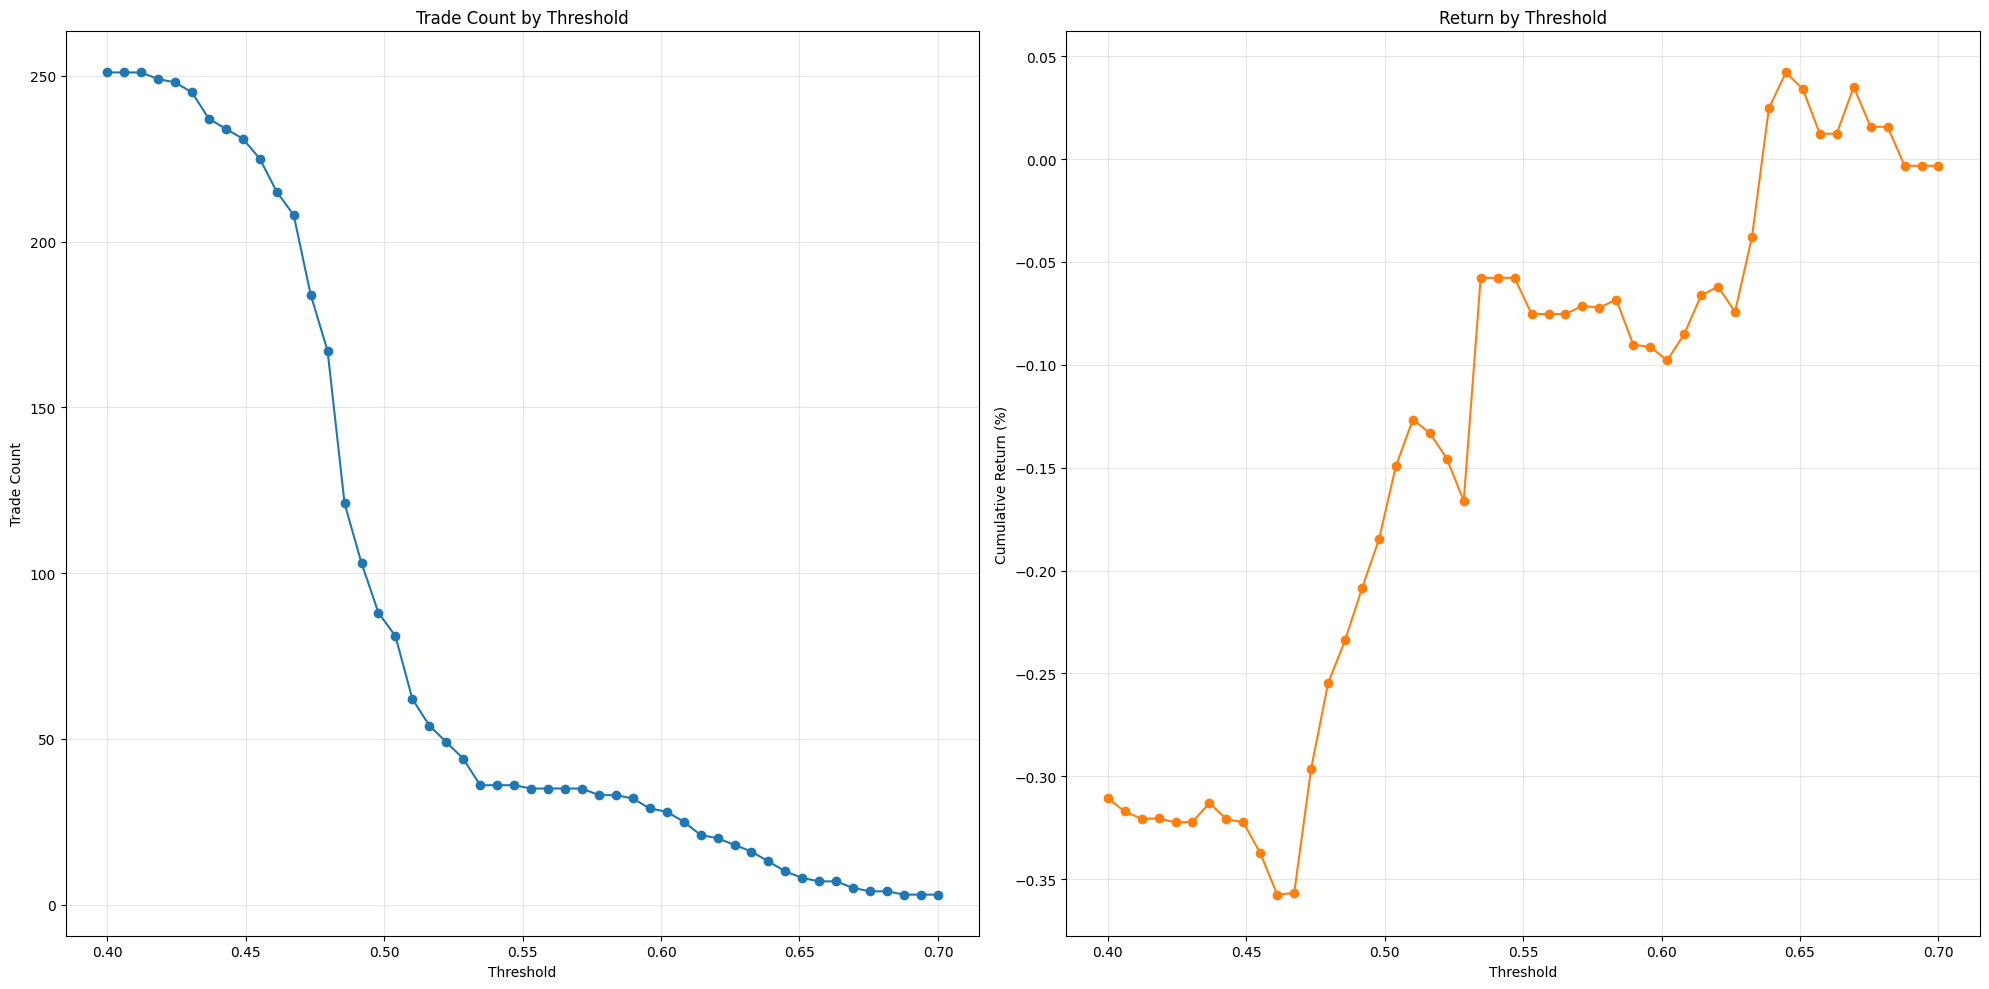

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

probs = model.predict_proba(X_backtest)[:, 1]


analysis = pd.DataFrame(
    {
        "Symbol": df.loc[X_backtest.index, "Symbol"],
        "Open": df.loc[X_backtest.index, "Open"],
        "Low": df.loc[X_backtest.index, "Low"],
        "High": df.loc[X_backtest.index, "High"],
        "Close": df.loc[X_backtest.index, "Close"],
        "Prob": probs,
        "Date": df.loc[X_backtest.index, "Date"],
    }
)

analysis = analysis.sort_values("Date").reset_index(drop=True)

returns = []
thresholds = np.linspace(0.4, 0.7, 50)
trade_amounts = []

for threshold in thresholds:

    TAKE_PROFIT = 0.02
    STOP_LOSS = 0.01
    COMMISSION = 0.001
    INITIAL_CAPITAL = 10000.0
    HOLD_PERIOD = 8

    trade_count = 0

    analysis["Signal"] = (analysis["Prob"] > threshold).astype(int)

    current_capital = INITIAL_CAPITAL
    in_trade = False
    entry_price = 0.0
    exit_step_limit = 0

    signals = analysis["Signal"].shift(1).fillna(0)

    for i in range(len(analysis)):
        row = analysis.iloc[i]

        current_open = row["Open"]
        current_low = row["Low"]
        current_high = row["High"]
        current_close = row["Close"]

        if in_trade:

            sl_price = entry_price * (1 - STOP_LOSS)
            hit_sl = current_low <= sl_price

            tp_price = entry_price * (1 + TAKE_PROFIT)
            hit_tp = current_high >= tp_price

            time_exit = i >= exit_step_limit

            exit_price = 0.0
            execute_exit = False

            if hit_sl:
                exit_price = (
                    min(current_open, sl_price) if current_open < sl_price else sl_price
                )

                execute_exit = True

            elif hit_tp:
                exit_price = (
                    max(current_open, tp_price) if current_open > tp_price else tp_price
                )

                execute_exit = True

            elif time_exit:
                exit_price = current_close
                execute_exit = True

            if execute_exit:
                raw_return = (exit_price - entry_price) / entry_price
                current_capital = current_capital * (1 + raw_return - COMMISSION)
                in_trade = False

        elif not in_trade:
            if signals[i] == 1:
                in_trade = True
                entry_price = current_open
                exit_step_limit = i + HOLD_PERIOD
                trade_count += 1

    total_return = (current_capital - INITIAL_CAPITAL) / INITIAL_CAPITAL
    returns.append(total_return)
    trade_amounts.append(trade_count)


ax1.plot(thresholds, trade_amounts, marker="o", color="tab:blue")
ax1.set_title("Trade Count by Threshold")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Trade Count")
ax1.grid(True, alpha=0.3)

ax2.plot(thresholds, returns, marker="o", color="tab:orange")
ax2.set_title("Return by Threshold")
ax2.set_xlabel("Threshold")
ax2.set_ylabel("Cumulative Return (%)")
ax2.grid(True, alpha=0.3)

plt.tight_layout()

idx = np.argmax(returns)

print(f"Trade Amount on max return: {trade_amounts[idx]}")
print(f"Max return: {returns[idx]}")